In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   novara
   2   teramo
   3   vicenza
   4   treviso
   5   ascoli_piceno
   6   avellino
   7   pistoia
   8   bergamo
   9   brindisi
   10   livorno
   11   cosenza
   12   rovigo
   13   modena
   14   imperia
   15   savona
   16   alessandria
   17   perugia
   18   matera
   19   padova
   20   ancona
   21   enna
   22   monza
   23   ragusa
   24   oristano
   25   belluno
   26   roma
   27   massa
   28   messina
   29   latina
   30   mantova
   31   ravenna
   32   l_aquila
   33   cuneo
   34   grosseto
   35   lecce
   36   reggio_di_calabria
   37   como
   38   sassari
   39   salerno
   40   genova
   41   palermo
   42   frosinone
   43   bari
   44   nuoro
   45   isernia
   46   bat
   47   ferrara
   48   firenze
   49   caltanissetta
   50   carbonia
   51   lucca
   52   rimini
   53   foggia
   54   milano
   55   rieti
   56   pisa
   57   varese
   58   biella
   59   agrigento
   

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    #if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    #if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 novara
2 teramo
3 vicenza
4 treviso
5 ascoli_piceno
6 avellino
7 pistoia
8 bergamo
9 brindisi
10 livorno
11 cosenza
12 rovigo
13 modena
14 savona
15 alessandria
16 perugia
17 matera
18 padova
19 ancona
20 enna
21 monza
22 oristano
23 belluno
24 roma
25 massa
26 latina
27 mantova
28 ravenna
29 l_aquila
30 cuneo
31 grosseto
32 lecce
33 reggio_di_calabria
34 como
35 sassari
36 salerno
37 genova
38 palermo
39 frosinone
40 bari
41 nuoro
42 bat
43 ferrara
44 firenze
45 lucca
46 rimini
47 foggia
48 milano
49 rieti
50 pisa
51 varese
52 biella
53 agrigento
54 catania
55 prato
56 cremona
57 trieste
58 bologna
59 macerata
60 pesaro
61 reggio_nell_emilia
62 lecco
63 caserta
64 chieti
65 piacenza
66 siena
67 brescia
68 viterbo
69 asti
70 parma
71 vercelli
72 la_spezia
73 verona
74 udine
75 terni
76 venezia
77 lodi
78 pescara
79 cagliari
80 forli
81 torino
82 crotone
83 sondrio
84 gorizia
85 napoli
86 trento
87 pordenone
88 vibo_valentia
89 taranto
90 pavia
91 benevento
92 potenza
93 arezzo
94 cat

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Using:         

Training set average RMSE:  0.35567  0.02174 
    Test set average RMSE:  0.97705  0.10520 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36106
                       R2:  0.93795


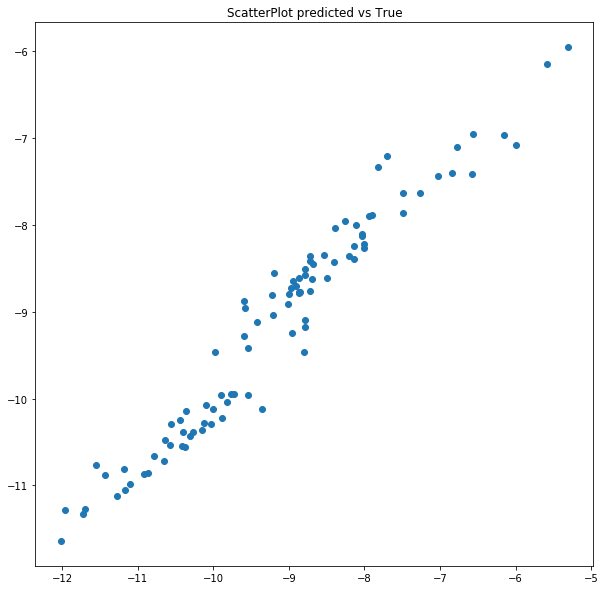

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03086
Feature:               commutersdensity, Score: 0.01532
Feature:                         depriv, Score: 0.02352
Feature:                            lat, Score: 0.63541
Feature:                 Ratio0200ver65, Score: 0.06194
Feature:           avg_wco_period1_2020, Score: 0.02940
Feature:          avg_wnh3_period1_2020, Score: 0.07525
Feature:           avg_wno_period1_2020, Score: 0.04162
Feature:           avg_wo3_period1_2020, Score: 0.04215
Feature:         avg_wpans_period1_2020, Score: 0.01825
Feature:          avg_wso2_period1_2020, Score: 0.02629


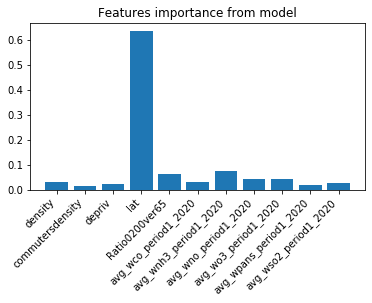

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04043
Feature:               commutersdensity, Score: 0.03327
Feature:                         depriv, Score: 0.04204
Feature:                            lat, Score: 2.50336
Feature:                 Ratio0200ver65, Score: 0.12982
Feature:           avg_wco_period1_2020, Score: 0.05210
Feature:          avg_wnh3_period1_2020, Score: 0.20854
Feature:           avg_wno_period1_2020, Score: 0.12349
Feature:           avg_wo3_period1_2020, Score: 0.07505
Feature:         avg_wpans_period1_2020, Score: 0.06043
Feature:          avg_wso2_period1_2020, Score: 0.05963


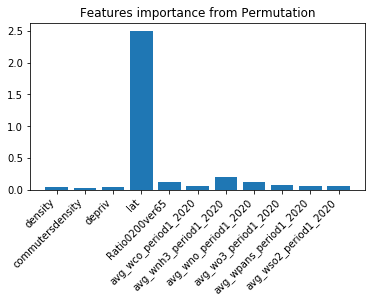

<Figure size 720x720 with 0 Axes>

((0.3556729967289475, 0.021736153018289975),
 (0.977052223351528, 0.10519925831917742),
 0.36105975967415965,
 {'density': 0.012148962182451649,
  'commutersdensity': 0.009996198266422862,
  'depriv': 0.01263236278580521,
  'lat': 0.7521736161393958,
  'Ratio0200ver65': 0.03900520374985118,
  'avg_wco_period1_2020': 0.015654252501716665,
  'avg_wnh3_period1_2020': 0.06265993542312458,
  'avg_wno_period1_2020': 0.03710525925145001,
  'avg_wo3_period1_2020': 0.022551245004173912,
  'avg_wpans_period1_2020': 0.01815759937152309,
  'avg_wso2_period1_2020': 0.01791536532408503})

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

Training set average RMSE:  0.38587  0.03349 
    Test set average RMSE:  1.02735  0.12022 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.38605
                       R2:  0.92906


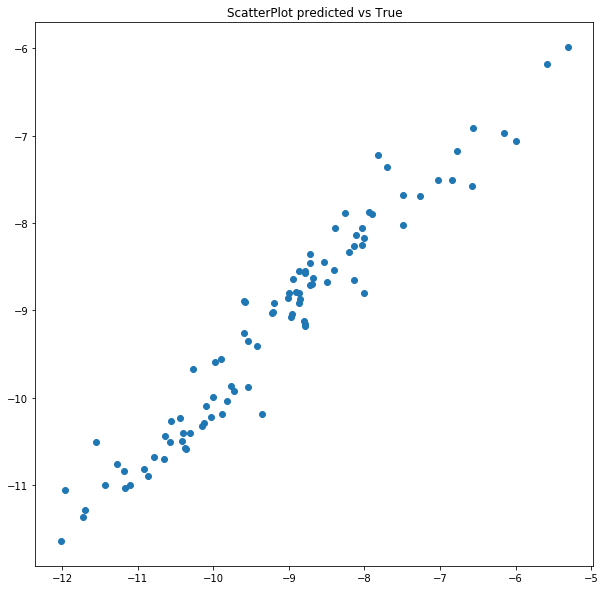

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03488
Feature:               commutersdensity, Score: 0.44645
Feature:                         depriv, Score: 0.03812
Feature:                 Ratio0200ver65, Score: 0.08306
Feature:           avg_wco_period1_2020, Score: 0.06777
Feature:          avg_wnh3_period1_2020, Score: 0.10266
Feature:           avg_wno_period1_2020, Score: 0.12058
Feature:           avg_wo3_period1_2020, Score: 0.04471
Feature:         avg_wpans_period1_2020, Score: 0.02745
Feature:          avg_wso2_period1_2020, Score: 0.03432


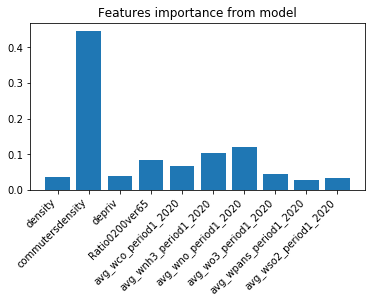

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.05950
Feature:               commutersdensity, Score: 1.29130
Feature:                         depriv, Score: 0.05636
Feature:                 Ratio0200ver65, Score: 0.16985
Feature:           avg_wco_period1_2020, Score: 0.14078
Feature:          avg_wnh3_period1_2020, Score: 0.16797
Feature:           avg_wno_period1_2020, Score: 0.28459
Feature:           avg_wo3_period1_2020, Score: 0.08233
Feature:         avg_wpans_period1_2020, Score: 0.06277
Feature:          avg_wso2_period1_2020, Score: 0.07409


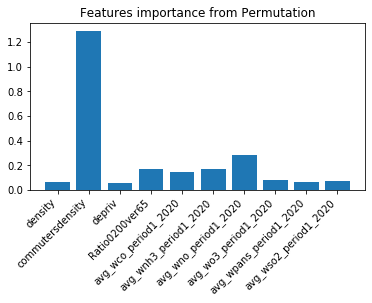

<Figure size 720x720 with 0 Axes>

((0.3858657088114949, 0.03348625857451918),
 (1.0273502589598618, 0.12021509624640084),
 0.3860477345979426,
 {'density': 0.02489846926191037,
  'commutersdensity': 0.5403991534911086,
  'depriv': 0.023584327985168806,
  'Ratio0200ver65': 0.07107887170984904,
  'avg_wco_period1_2020': 0.05891674553940404,
  'avg_wnh3_period1_2020': 0.07029593546452212,
  'avg_wno_period1_2020': 0.11909670292993907,
  'avg_wo3_period1_2020': 0.034456351239624906,
  'avg_wpans_period1_2020': 0.02626669324603757,
  'avg_wso2_period1_2020': 0.031006749132435656})

In [6]:
featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

Training set average RMSE:  0.40316  0.02722 
    Test set average RMSE:  1.04694  0.13376 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.37863
                       R2:  0.93176


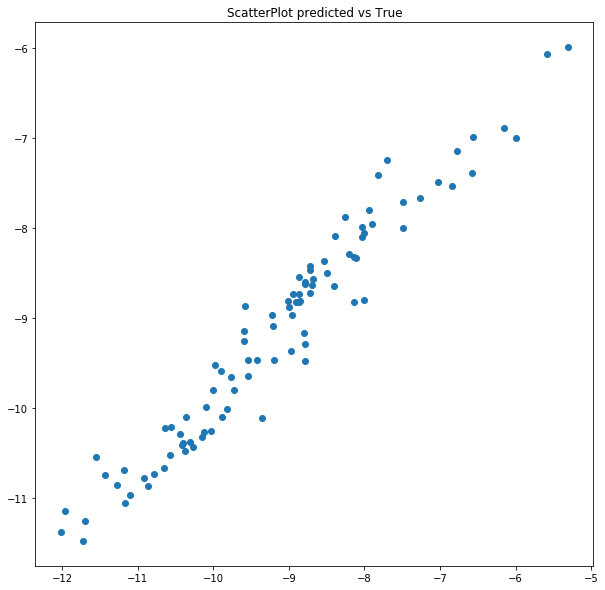

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03447
Feature:                         depriv, Score: 0.19757
Feature:                 Ratio0200ver65, Score: 0.07202
Feature:           avg_wco_period1_2020, Score: 0.13006
Feature:          avg_wnh3_period1_2020, Score: 0.13836
Feature:           avg_wno_period1_2020, Score: 0.28936
Feature:           avg_wo3_period1_2020, Score: 0.05361
Feature:         avg_wpans_period1_2020, Score: 0.04054
Feature:          avg_wso2_period1_2020, Score: 0.04400


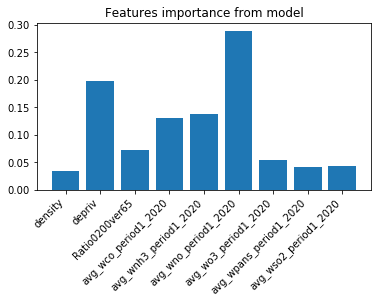

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.06873
Feature:                         depriv, Score: 0.59901
Feature:                 Ratio0200ver65, Score: 0.12718
Feature:           avg_wco_period1_2020, Score: 0.17475
Feature:          avg_wnh3_period1_2020, Score: 0.31285
Feature:           avg_wno_period1_2020, Score: 0.58738
Feature:           avg_wo3_period1_2020, Score: 0.08347
Feature:         avg_wpans_period1_2020, Score: 0.09009
Feature:          avg_wso2_period1_2020, Score: 0.10248


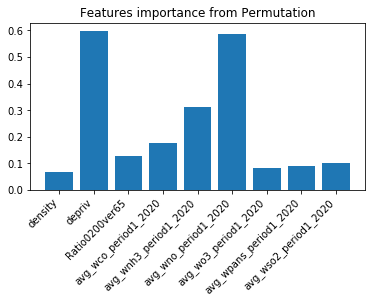

<Figure size 720x720 with 0 Axes>

((0.4031567923442612, 0.027221077475956958),
 (1.046944726564008, 0.13376134069632628),
 0.37862858827748785,
 {'density': 0.03203007905682745,
  'depriv': 0.279137660038525,
  'Ratio0200ver65': 0.05926561105102772,
  'avg_wco_period1_2020': 0.08143305198973469,
  'avg_wnh3_period1_2020': 0.14578640644924198,
  'avg_wno_period1_2020': 0.27371431267517277,
  'avg_wo3_period1_2020': 0.03889769892503211,
  'avg_wpans_period1_2020': 0.0419795333932145,
  'avg_wso2_period1_2020': 0.047755646421223784})

In [7]:
featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

In [13]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf = smlmodule.rfregressors_custom_optimizer (X, Y)

print(bestf)

1  of  2400 MSE:  0.1303641500559619
2  of  2400 MSE:  0.12004861286206814
3  of  2400 MSE:  9.221420851522872e-10
4  of  2400 MSE:  3.6885683402629455e-13
5  of  2400 MSE:  0.19524148229312074
6  of  2400 MSE:  0.23264453909267188
7  of  2400 MSE:  0.1060713839357641
8  of  2400 MSE:  0.05579837255038529
9  of  2400 MSE:  0.42921270949135293
10  of  2400 MSE:  0.52375678166112
11  of  2400 MSE:  0.3287722699864988
12  of  2400 MSE:  0.3074120162107862
13  of  2400 MSE:  0.6060889484986902
14  of  2400 MSE:  0.6987207341862316
15  of  2400 MSE:  0.5907794231348682
16  of  2400 MSE:  0.5686811139890472
17  of  2400 MSE:  0.18300465046866393
18  of  2400 MSE:  0.19523622234073246
19  of  2400 MSE:  0.08277274830190558
20  of  2400 MSE:  0.043070563057996565
21  of  2400 MSE:  0.21834711448104002
22  of  2400 MSE:  0.2591005238541229
23  of  2400 MSE:  0.11858347345780405
24  of  2400 MSE:  0.06862085993101681
25  of  2400 MSE:  0.42921270949135293
26  of  2400 MSE:  0.52375678166112
27  

Training set average RMSE:  1.46309  0.07944 
    Test set average RMSE:  1.42455  0.14867 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  1.44981
                       R2: -0.00053


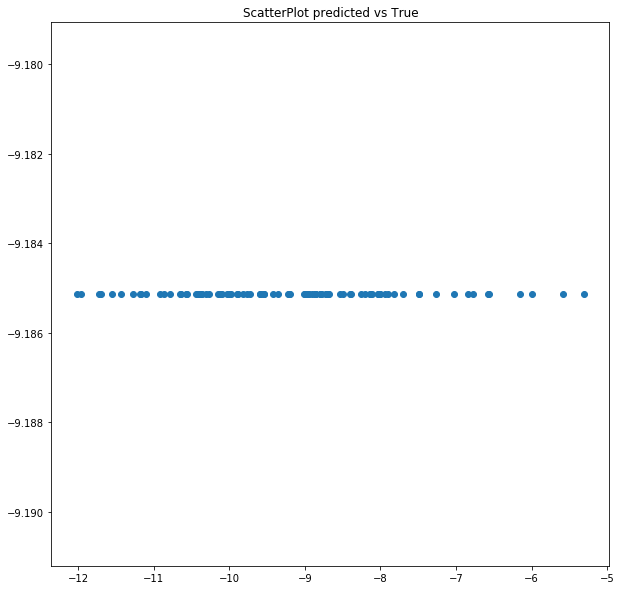

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.00000
Feature:               commutersdensity, Score: 0.00000
Feature:                         depriv, Score: 0.00000
Feature:                            lat, Score: 0.00000
Feature:                 Ratio0200ver65, Score: 0.00000
Feature:           avg_wco_period1_2020, Score: 0.00000
Feature:          avg_wnh3_period1_2020, Score: 0.00000
Feature:           avg_wno_period1_2020, Score: 0.00000
Feature:           avg_wo3_period1_2020, Score: 0.00000
Feature:         avg_wpans_period1_2020, Score: 0.00000
Feature:          avg_wso2_period1_2020, Score: 0.00000


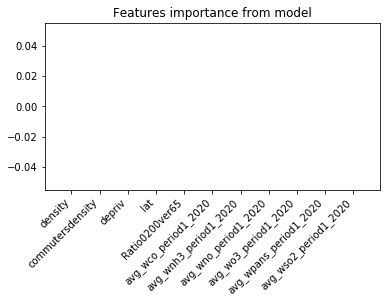

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.03983
Feature:               commutersdensity, Score: 0.02842
Feature:                         depriv, Score: 0.04022
Feature:                            lat, Score: 2.58846
Feature:                 Ratio0200ver65, Score: 0.12426
Feature:           avg_wco_period1_2020, Score: 0.05273
Feature:          avg_wnh3_period1_2020, Score: 0.22626
Feature:           avg_wno_period1_2020, Score: 0.10338
Feature:           avg_wo3_period1_2020, Score: 0.10457
Feature:         avg_wpans_period1_2020, Score: 0.04560
Feature:          avg_wso2_period1_2020, Score: 0.06370


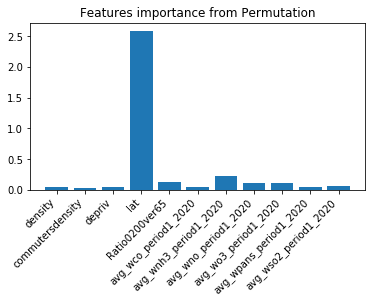

<Figure size 720x720 with 0 Axes>

((1.4630869157776685, 0.07944132514868504),
 (1.4245500535903235, 0.14866765975719368),
 1.4498103598780037,
 {'density': 0.011654331356742396,
  'commutersdensity': 0.008315476736178525,
  'depriv': 0.011768552034364966,
  'lat': 0.7574292409853034,
  'Ratio0200ver65': 0.036361688114632335,
  'avg_wco_period1_2020': 0.0154303234125387,
  'avg_wnh3_period1_2020': 0.06620721353558295,
  'avg_wno_period1_2020': 0.03025167153771211,
  'avg_wo3_period1_2020': 0.030598666682830098,
  'avg_wpans_period1_2020': 0.013344347750354403,
  'avg_wso2_period1_2020': 0.01863848785376004})

In [14]:
#importlib.reload(smlmodule)
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

#print(bestf.best_estimator_)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True, optimisedparams=bestf)